## Let's try to use EventFilter regressor for ranking problems

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import h5py
import pandas
from sklearn.metrics import mean_squared_error

In [7]:
def load_h5(name):
    print "reading from",name
    h5f = h5py.File(name,'r')
    labels = h5f['labels'][:]
    qids = h5f['qids'][:]
    features = h5f['features'][:]
    h5f.close()
    print "done"
    sorter = numpy.argsort(qids)
    return features[sorter], qids[sorter], labels[sorter]

In [12]:
Xtr,Qtr,Ytr = load_h5("../data/MSLR/mslr_train")
Xts,Qts,Yts = load_h5("../data/MSLR/mslr_test")

reading from ../data/MSLR/mslr_train
done
reading from ../data/MSLR/mslr_test
done


In [32]:
print len(Xtr), len(Xts)

723412 241521


In [50]:
from rep_ef.estimators import EventFilterRegressor
ef = EventFilterRegressor(iterations=10000, connection='test_connection', dataset_name='letor-{random}')

In [ ]:
%%time
ef.fit(Xtr, Ytr)

In [63]:
import cPickle
with open('../data/MSLR10k_ef.mx', 'w') as f:
    cPickle.dump(ef.formula_mx, f)

In [64]:
with open('../data/MSLR10k_ef.mx', 'r') as f:
    formula_mx = cPickle.load(f)

In [89]:
from _matrixnetapplier import MatrixnetClassifier
from StringIO import StringIO

In [72]:
mean_squared_error(Yts, ef.predict(Xts))

0.55456890206334308

In [91]:
mn = MatrixnetClassifier(StringIO(formula_mx))
mean_squared_error(Yts, mn.apply(Xts))

0.55456890206334308

In [56]:
from itertools import islice
def plot_mse_curves(clf, step=5):
    mses_ts = []
    for p in islice(clf.staged_predict(Xts), None, None, step):
        mses_ts.append(mean_squared_error(Yts, p))
    mses_tr = []
    for p in islice(clf.staged_predict(Xtr), None, None, step):
        mses_tr.append(mean_squared_error(Ytr, p))
    plot(mses_ts)
    plot(mses_tr)
    return mses_tr, mses_ts

((0.5, 0.6), None)

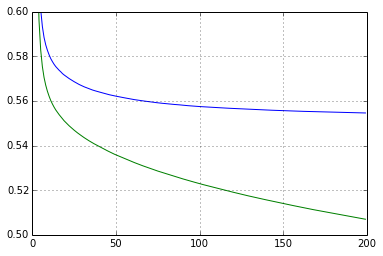

In [93]:
mses_ef = plot_mse_curves(ef)
ylim(0.5, 0.6), grid()

In [60]:
min(mses_ef[0]), min(mses_ef[1]), mses_ef[1][-10:]

(0.50697425031279097,
 0.55458356173258117,
 [0.55475070471440302,
  0.55473671464244989,
  0.55472513045849425,
  0.55470452983041052,
  0.55467808433063848,
  0.55465632072651216,
  0.55463884809056962,
  0.55461392479790939,
  0.55460524375293818,
  0.55458356173258117])

# Event filter with different learning_rates

In [94]:
ef_collection = {}

In [ ]:
%%time
from rep_ef.estimators import EventFilterRegressor
for reg in [0.01, 0.03, 0.1, 0.3]:
    ef = EventFilterRegressor(iterations=600, connection='test_connection', dataset_name='letor-{random}', 
                              regularization=reg)
    ef.fit(Xtr, Ytr)
    ef_collection[reg] = ef

CPU times: user 3min 51s, sys: 14 s, total: 4min 5s
Wall time: 2h 36min 9s


0.01 0.578986463953


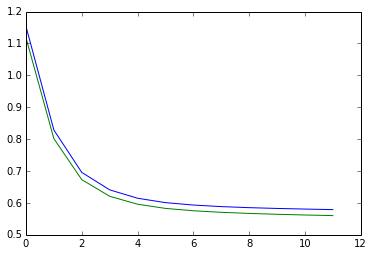

0.03 0.565061281506


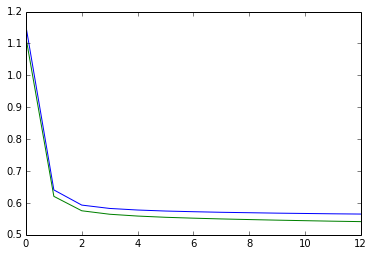

0.1 0.557704858878


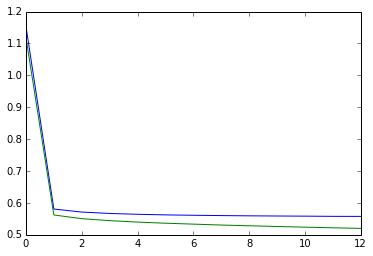

0.3 0.559274886615


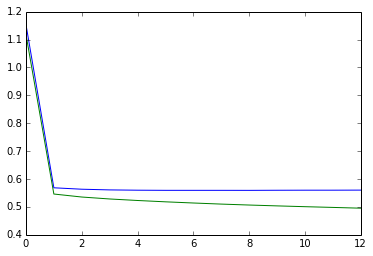

In [104]:
for reg, clf in sorted(ef_collection.iteritems()):
    mses_tr, mses_ts = plot_mse_curves(clf)
    print reg, min(mses_ts)
    show()